# Naive Risk Budgeting Strategies between PSP and GHP

$Objective:$ find a way to get the optimal weights for Performace Seeking Portfolio and the Liability Hedging Portfolio.

In [6]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
%matplotlib inline

In [7]:
import Basic_Risk_Assessment_Tools as brat

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's write a function that'll use the returns from the PSP and LHP and use an `allocator` function, which we'll eventually write, and give us the returns of the complete Portfolio.

In [9]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

### The Simplest Allocator - Fixed Mix

The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second

In [10]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

Using the `allocator` to get the returns for a Bond Portfolio of $60$% $10y$ $bond$ and $40$% $30y$ $bond$  we get....

In [11]:
rates, zc_prices = brat.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = brat.bond_price(10, 100, .05, 12, rates)
price_30 = brat.bond_price(30, 100, .05, 12, rates)
returns_10 = brat.bond_total_return(price_10, 100, .05, 12)
returns_30 = brat.bond_total_return(price_30, 100, .05, 12)
returns_bond_port = brat.bt_mix(returns_10, returns_30, allocator=brat.fixedmix_allocator, w1=0.6)
mean_returns_bonds = returns_bond_port.mean(axis="columns")
brat.summary_stats({'Mean Bond Returns': pd.DataFrame(data=mean_returns_bonds, columns=['Mean Bond Returns'])}, annualizing_factor=12, risk_free_return=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
Mean Bond Returns,0.003566,0.035785,10.036306,1.579004,-0.155513,0.002935,0.00305,False,-0.661683,1.683261,False,0.0,-0.001249,-0.001099,-0.000719,-0.001551


We now generate Simulated Equity Returns and Returns for a Zero Coupon Bond.

In [13]:
price_equity = brat.geo_brown_motion(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15, steps_per_year=12)
returns_equity = price_equity.pct_change().dropna()
returns_zc = zc_prices.pct_change().dropna()

Using the Bond Portfolio Returns and the Equity Returns we build a portfolio of $70$% $stocks$ and $30$% $bonds$ 

In [71]:
portfolio_returns = brat.bt_mix(returns_equity, returns_bond_port, allocator=brat.fixedmix_allocator, w1=0.7)
mean_portfolio_returns = portfolio_returns.mean(axis='columns')
brat.summary_stats({'Mean Portfolio Returns': pd.DataFrame(data=mean_portfolio_returns, columns=['Mean Portfolio Returns'])}, annualizing_factor=12, risk_free_return=0.03)

,Annualized Volatility,Annualized Returns,Return to Risk Ratio,Sharpe Ratio,Max Drawdown in %,Returns Mean,Returns Median,Negatively Skewed?,Skewness,Excess Kurtosis,Normal as per Jarque?,Semi-Deviation,Gaussian VaR,Cornish-Fisher VaR,Conditional VaR,Historical VaR
Mean Portfolio Returns,0.004966,0.06256,12.596718,6.381087,0.0,0.005071,0.005038,True,-0.057112,-0.322483,True,NaN,-0.002722,-0.00269,-0.002203,-0.002664


It is evident that the Annualised Returns for the combined portfolio is 6%, which is an improvement from the 3.5% return from the Bond Portfolio. The Sharpe Ratio also shows a tremendous improvement to 6.3%.

However, this greater return also comes with an added risk which can be seen in the higher Value at Risk parameters.

Another approach is to compute stats on each scenario and then average the stats, rather than average the returns across all the scenarios....


In [72]:
portfolio_returns_dict = {}
for header in list(portfolio_returns.columns):
    portfolio_returns_dict[header] = pd.DataFrame(data=portfolio_returns[header], columns=[header])
brat.summary_stats(portfolio_returns_dict, annualizing_factor=12, risk_free_return=0.03).mean()

Annualized Volatility     0.107631
Annualized Returns        0.057027
Return to Risk Ratio      0.533272
Sharpe Ratio              0.246476
Max Drawdown in %       -20.335610
Returns Mean              0.005071
Returns Median            0.005026
Negatively Skewed?        0.530000
Skewness                  0.004842
Excess Kurtosis          -0.032613
Normal as per Jarque?     0.970000
Semi-Deviation            0.017575
Gaussian VaR              0.045822
Cornish-Fisher VaR        0.045778
Conditional VaR           0.057902
Historical VaR            0.045035
dtype: float64

To check performance we are adding a $floor$ value, which we do not wish to breach, and a $cap$ value for which we wish to know if we're exceeding.  

In [73]:
def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

In [76]:
def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    "mean": average terminal wealth,
    "std" : deviation of terminal wealths from mean,
    "breach_count": count of floor breaches,
    "reach_count": count of cap breach,
    "p_breach": probability of breach,
    "e_short":average value of deviation from floor if floor is being breached,
    "p_reach": probability of reach,
    "e_surplus": average value of deviation from cap if cap is being breached
    """
    terminal_wealth = terminal_values(rets)
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    breach_count = breach.sum()
    reach_count = breach.sum()
    p_breach = breach.mean() if breach.sum() > 0 else 'N/A'
    p_reach = reach.mean() if reach.sum() > 0 else 'N/A'
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else 'N/A'
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else 'N/A'
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "breach_count": breach_count,
        "reach_count": reach_count,
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

In [77]:
pd.concat([brat.terminal_stats(returns_bond_port, name="Fixed Income"), 
           brat.terminal_stats(returns_equity, name="Equities"),
           brat.terminal_stats(portfolio_returns, name="70 Eq - 30 Bond")],
          axis=1)

,Fixed Income,Equities,70 Eq - 30 Bond
mean,1.38189,2.03863,1.82576
std,0.105811,0.994917,0.606387
breach_count,0,22,4
reach_count,0,22,4
p_breach,N/A,0.044,0.008
e_short,N/A,0.11316,0.10901
p_reach,N/A,N/A,N/A
e_surplus,N/A,N/A,N/A


This shows that the average return of the $70$% $stocks$ and $30$% $bonds$ $portfolio$ is much higher than a $Bond$ $Portfolio$ but less than investing only in $Equities$.

However, the chances of breaching the floor are considerably less in the case of a $stocks$ and $bonds$ $portfolio$ as compared to $Equity$ $Portfolio$ which makes the hybrid portfolio highly lucrative.

Looking at the distribution of the $Terminal$ $Values$.....

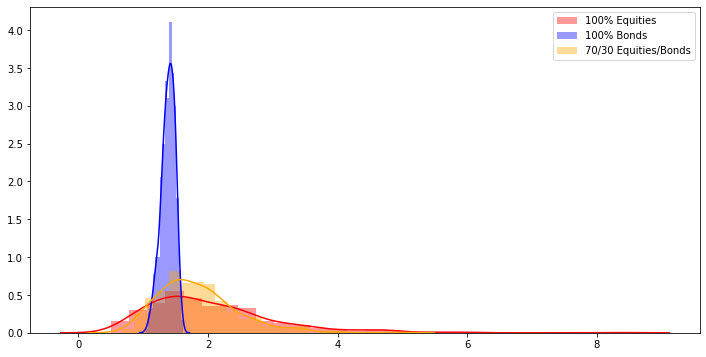

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(brat.terminal_values(returns_equity), color="red", label="100% Equities")
sns.distplot(brat.terminal_values(returns_bond_port), color="blue", label="100% Bonds")
sns.distplot(brat.terminal_values(portfolio_returns), color="orange", label="70/30 Equities/Bonds")
plt.legend();

Note how the higher mean return of the equities portfolio is due in part to the large upside spread in equities.

## Risk Budgeting through Glide Path Allocation

A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepath that starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

In [80]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide, through equal steps,
    over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [84]:
portfolio_returns_glide = brat.bt_mix(returns_equity, returns_bond_port, allocator=brat.glidepath_allocator, start_glide=0.8, end_glide=0.2)
portfolio_returns_7030z = brat.bt_mix(returns_equity, returns_zc, allocator=brat.fixedmix_allocator, w1=0.7)
pd.concat([brat.terminal_stats(returns_bond_port, name="Fixed Income"), 
           brat.terminal_stats(returns_equity, name="Equity"),
           brat.terminal_stats(portfolio_returns, name="Naive 70/30"),
           brat.terminal_stats(portfolio_returns_glide, name="Glide 80 to 20"),
           brat.terminal_stats(portfolio_returns_7030z, name="Naive 70/30 Zero Coupon")],
          axis=1)

,Fixed Income,Equity,Naive 70/30,Glide 80 to 20,Naive 70/30 Zero Coupon
mean,1.38189,2.03863,1.82576,1.70736,1.79997
std,0.105811,0.994917,0.606387,0.428147,0.599562
breach_count,0,22,4,1,4
reach_count,0,22,4,1,4
p_breach,N/A,0.044,0.008,0.002,0.008
e_short,N/A,0.11316,0.10901,0.074661,0.102152
p_reach,N/A,N/A,N/A,N/A,N/A
e_surplus,N/A,N/A,N/A,N/A,N/A


A simple Glidepath Investment Strategy is slightly safer than the Naive Fixed Mix Allocator because the number of breaches reduce. However, it comes at the cost of mean return.

### Conclusion

Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities.